In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect 

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine, reflect=True) 

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement=Base.classes.measurement
station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [16]:
#what does the data look like
first_row_measurement = session.query(measurement)
first_row_measurement.__dict__

{'session': <sqlalchemy.orm.session.Session at 0x7facc8140c40>,
 '_propagate_attrs': immutabledict({'compile_state_plugin': 'orm', 'plugin_subject': <Mapper at 0x7facf8d5ee50; measurement>}),
 '_raw_columns': [Table('measurement', MetaData(), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None)]}

In [17]:
#what does the data look like
first_row_station = session.query(station)
first_row_station.__dict__

{'session': <sqlalchemy.orm.session.Session at 0x7facc8140c40>,
 '_propagate_attrs': immutabledict({'compile_state_plugin': 'orm', 'plugin_subject': <Mapper at 0x7facc80fd040; station>}),
 '_raw_columns': [Table('station', MetaData(), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)]}

In [20]:
inspector = inspect(engine) 

In [28]:
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [29]:
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set.
Recent_Date = session.query(measurement.date).order_by(measurement.date).first()
print(f"The most recent date in the data set is {Recent_Date[0]}")

The most recent date in the data set is 2010-01-01


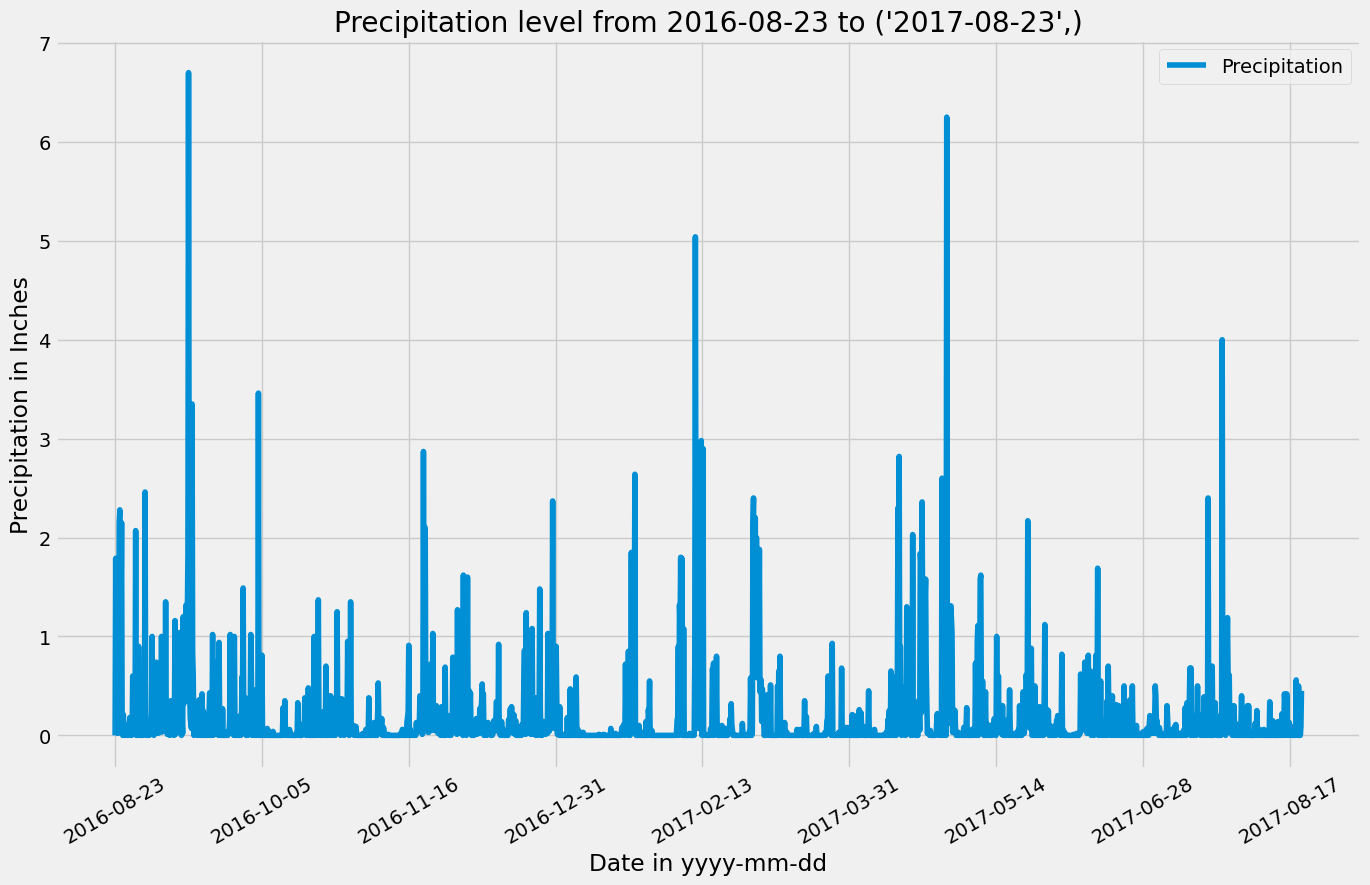

In [123]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
Last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
#Last_date -> returned '2017-08-23'

one_year_less=dt.date(2017,8,23)-dt.timedelta(days=365)
#one_year_less

# Perform a query to retrieve the data and precipitation scores
scores=[measurement.prcp,measurement.date]
queryscores=session.query(*scores).filter(measurement.date>=one_year_less).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation=pd.DataFrame(queryscores,columns=["Precipitation","Date"]).set_index("Date")
#precipitation=precipitation.dropna(how="any")
#precipitation=precipitation.set_index("Date")
#precipitation.head()

# Sort the dataframe by date
precipitation=precipitation.sort_values(by="Date",ascending=True).dropna()
precipitation.head()

#plot the dataframe
precipitation.plot(rot=30,figsize=(15,9))

plt.title(f"Precipitation level from {one_year_less} to {Last_date}")
plt.xlabel("Date in yyyy-mm-dd")
plt.ylabel("Precipitation in Inches")
plt.legend()
plt.show()

In [84]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [86]:
# Design a query to calculate the total number stations in the dataset
number_of_stations= session.query(station.id).count()
print(f"There are {number_of_stations} stations in the dataset")

There are 9 stations in the dataset


In [95]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station_list=session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station)
sorted_list=active_station_list.order_by(func.count(measurement.station).desc()).all()
sorted_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [99]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_id='USC00519281'
calculate=session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).filter(measurement.station==active_station_id).all()
calculate

[(54.0, 85.0, 71.66378066378067)]

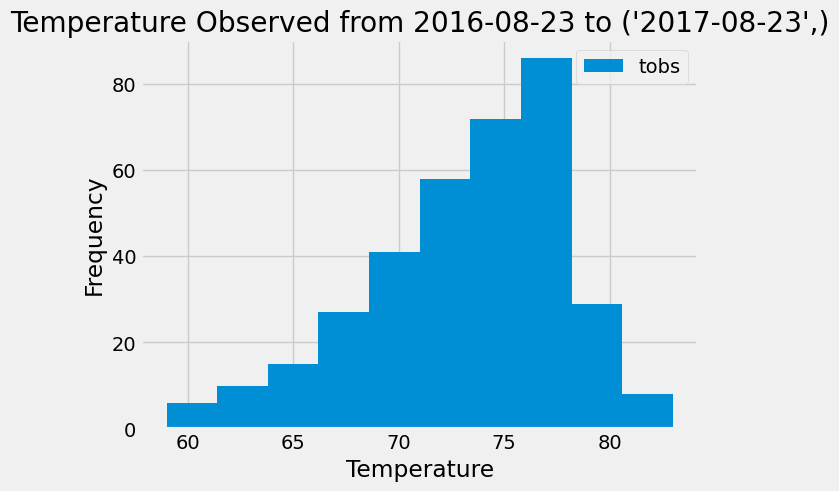

<Figure size 1500x900 with 0 Axes>

In [121]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station=sorted_list[0][0]
querytemperature=session.query(measurement.date,measurement.tobs).\
                 filter(measurement.date>="2016-08-23").\
                 filter(measurement.date<= "2017-08-23").\
                 filter(measurement.station==most_active_station).all()

querytemperature_df=pd.DataFrame(querytemperature)
histogram=querytemperature_df.plot.hist(bins=10)

plt.title(f"Temperature Observed from {one_year_less} to {Last_date}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.figure(figsize = (15,9))
plt.show()

# Close session

In [122]:
# Close Session
session.close()